In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

In [50]:
selected_state = "Florida"
dataset = pd.read_csv("data/final_dataset.csv")
dataset = dataset[dataset["state_" + selected_state] == True]

dropped_columns = [c for c in dataset.columns if c.startswith('state_')]
dataset_reduced = dataset.drop(columns=dropped_columns, axis = 1)
dataset_reduced.drop(columns=["min_age_participants", "max_age_participants", "totalvotes", "teen_ratio", "povertyPercentage", "year", "democrats_ratio", "party"], axis=1, inplace=True)

dataset_reduced.head()

,date,populous_city,latitude,longitude,avg_age_participants,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,republicans_ratio,month_x,month_y
26,1132.0,0,30.1979,-81.7632,36.0,1.0,1.0,0.0,0.0,0.0,2.0,0.357657,-2.449294e-16,1.000000
65,771.0,0,28.5805,-81.4528,16.0,0.0,1.0,0.0,1.0,0.0,1.0,0.345250,-8.660254e-01,0.500000
119,771.0,0,30.1764,-81.8440,26.0,1.0,1.0,0.0,0.0,0.5,2.0,0.649848,-5.000000e-01,-0.866025
163,1492.0,0,27.8938,-82.6883,33.0,1.0,1.0,0.0,1.0,0.0,1.0,0.480969,-5.000000e-01,-0.866025
172,411.0,0,28.1418,-81.4501,18.0,1.0,1.0,0.0,0.0,0.0,2.0,0.460254,-8.660254e-01,-0.500000


In [51]:
numeric_dataset = dataset_reduced._get_numeric_data()
numeric_dataset.head()

,date,populous_city,latitude,longitude,avg_age_participants,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,republicans_ratio,month_x,month_y
26,1132.0,0,30.1979,-81.7632,36.0,1.0,1.0,0.0,0.0,0.0,2.0,0.357657,-2.449294e-16,1.000000
65,771.0,0,28.5805,-81.4528,16.0,0.0,1.0,0.0,1.0,0.0,1.0,0.345250,-8.660254e-01,0.500000
119,771.0,0,30.1764,-81.8440,26.0,1.0,1.0,0.0,0.0,0.5,2.0,0.649848,-5.000000e-01,-0.866025
163,1492.0,0,27.8938,-82.6883,33.0,1.0,1.0,0.0,1.0,0.0,1.0,0.480969,-5.000000e-01,-0.866025
172,411.0,0,28.1418,-81.4501,18.0,1.0,1.0,0.0,0.0,0.0,2.0,0.460254,-8.660254e-01,-0.500000


In [52]:
numeric_dataset.values.shape

(15005, 14)

In [53]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(numeric_dataset.values)
scaled_dataset.shape

(15005, 14)

In [54]:
k = 3
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1).fit(scaled_dataset)
distances, indices = nbrs.kneighbors(scaled_dataset)
kth_distances = distances[:, k]
distances.shape

(15005, 4)

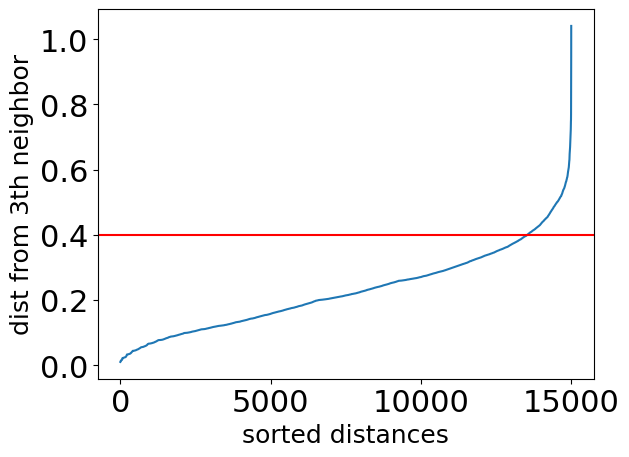

In [94]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.axhline(y = 0.4, color = 'r')
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [98]:
dbscan = DBSCAN(eps=0.43, min_samples=150)
dbscan.fit(scaled_dataset)
labels, cluster_num_points = np.unique(dbscan.labels_, return_counts=True)
n_clusters = len(labels)
cluster_num_points

array([6806, 2374, 2546, 2085, 1194])

In [99]:
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset[dbscan.labels_ == i-1])

In [100]:
print('Silhouette %s' % silhouette_score(scaled_dataset, dbscan.labels_))
print('Davies-Bouldin %s' % davies_bouldin_score(scaled_dataset, dbscan.labels_))

Silhouette 0.09757610783782611
Davies-Bouldin 2.3470068972008606


/home/filippo/uni/DM/DataMiningProject/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/filippo/uni/DM/DataMiningProject/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[]

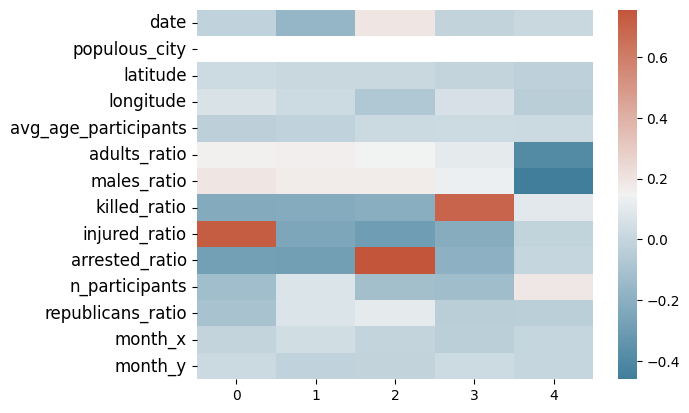

In [101]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(dbscan.labels_), n_clusters))
onehot[np.arange(len(dbscan.labels_)), dbscan.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset.shape[1], scaled_dataset.shape[1]:], fmt = '.2f', cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset.shape[1]) + 0.5, numeric_dataset.columns, rotation=0, fontsize=12)
[]

([], [])

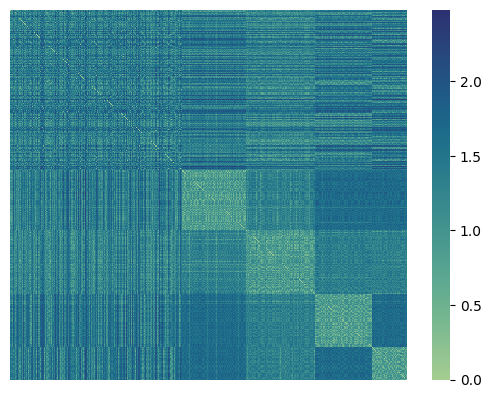

In [103]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset[samples]
downsampled_labels = dbscan.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])

In [68]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = tsne.fit_transform(scaled_dataset)

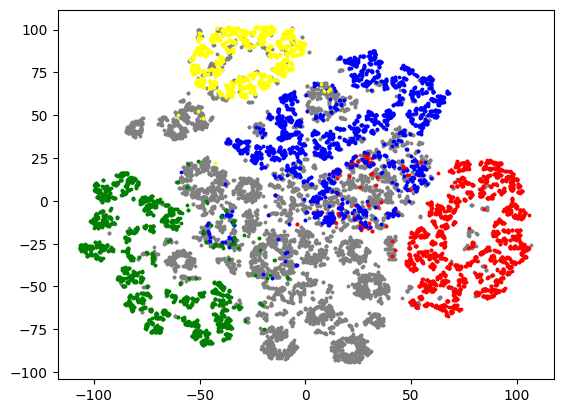

In [104]:
colors = ['gray', 'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'brown']
for i in range(n_clusters):
    plt.scatter(tsne_dataset[:,0][dbscan.labels_ == i-1], tsne_dataset[:,1][dbscan.labels_ == i-1], s=3, c=colors[i])
plt.show()

In [70]:
umap_reducer = UMAP().fit(scaled_dataset)


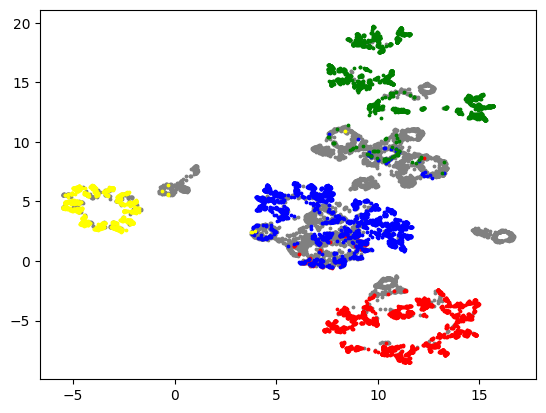

In [105]:
umap_dataset = umap_reducer.transform(scaled_dataset)
for i in range(n_clusters):
    plt.scatter(umap_dataset[:,0][dbscan.labels_ == i-1], umap_dataset[:,1][dbscan.labels_ == i-1], s=3, c=colors[i])
plt.show()

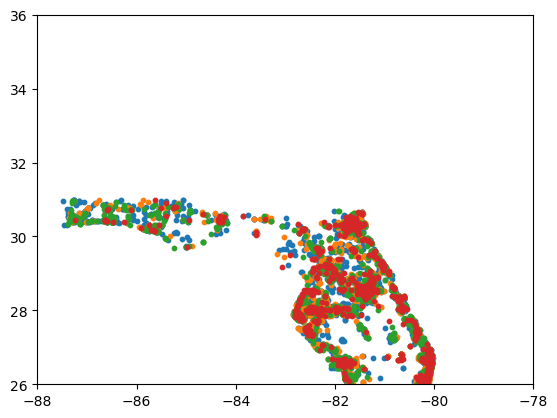

In [93]:
for i in range(n_clusters):
    plt.scatter(numeric_dataset["longitude"][dbscan.labels_ == i-1], numeric_dataset["latitude"][dbscan.labels_ == i-1], s=10)

plt.xlim(-88, -78)
plt.ylim(26, 36)
plt.show()